# Association between structural brain organisation and Maths and Reading abilities in children

## Loading the required python modules

In [247]:
from IPython.display import display
from ipywidgets import FloatProgress
import warnings
warnings.filterwarnings('ignore')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [248]:
import pandas as pd
pd.set_option('display.max_rows', 20)
from scipy import stats  
import bct
import os 
import numpy as np
import networkx as nx
from nilearn import plotting
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from statsmodels.formula.api import ols
from scipy.stats import ttest_rel, ttest_ind
import matplotlib.pyplot as plt
plt.style.use(['seaborn-paper', 'seaborn-colorblind'])

Setting figure aestethics to match journal style

In [249]:
from matplotlib import rcParams  
rcParams['font.family'] = 'serif'  
rcParams['font.serif'] = ['Computer Modern Unicode']  
rcParams['text.usetex'] = True  
rcParams['axes.labelsize'] = 9  
rcParams['xtick.labelsize'] = 9  
rcParams['ytick.labelsize'] = 9  
rcParams['legend.fontsize'] = 9  
mm2inches = 0.039371
single_column = 90*mm2inches
double_column = 190*mm2inches
one_half_column = 140*mm2inches

Path to save result figures:

In [250]:
outpath = '/imaging/jb07/CALM/DWI/FA_connectome/result_figures/'

## Preprocessing steps

First, data is loaded and a tidy data frame is created with all the relevant variables and only complete cases

In [251]:
def get_subject_behavioural_data(subject):
    import json
    behavioural = eval(open('/imaging/jb07/CALM/CALM_BIDS/' + subject + '/beh/' + subject + '_beh.txt', 'r').read().replace("NaN","float('nan')").replace("null","float('nan')"))
    behavioural.update(eval(open('/imaging/jb07/CALM/CALM_BIDS/' + subject + '/' + subject + '_demographics.txt', 'r').read().replace("NaN","float('nan')").replace("null","float('nan')")))

    return behavioural

In [252]:
# Setting up the progress bar
w = FloatProgress(value=0, min=0, max=100, step=0.1, description='Progress:')
display(w)
counter = 0

folder = '/imaging/jb07/CALM/DWI/FA_connectome/'
df = pd.DataFrame()
in_files = [folder + subfolder + '/calc_matrix/coreg_tracks_FA_matrix.txt' for subfolder in os.listdir(folder) if os.path.isfile(folder + subfolder + '/calc_matrix/coreg_tracks_FA_matrix.txt')]
networks = list()
subjects = list()

# Getting all the datab
for subfolder in os.listdir(folder):
    subject = subfolder.split('_')[-1]
    
    if (os.path.isfile(folder + subfolder + '/calc_matrix/coreg_tracks_FA_matrix.txt')):
        
        # Getting behavioural measures
        df.set_value(subject,'age', get_subject_behavioural_data(subject)['Age_in_months'])
        df.set_value(subject, 'Gender', get_subject_behavioural_data(subject)['Gender'])
        df.set_value(subject, 'Maths', get_subject_behavioural_data(subject)['WIAT_Numerical_raw'])
        df.set_value(subject, 'Reading', get_subject_behavioural_data(subject)['WIAT_Reading_Raw'])
        
        df.set_value(subject, 'Maths_std', get_subject_behavioural_data(subject)['WIAT_Numerical_Std'])
        df.set_value(subject, 'Reading_std', get_subject_behavioural_data(subject)['WIAT_Reading_Std'])

        # Getting graph measures
        data = np.loadtxt(folder + subfolder + '/calc_matrix/coreg_tracks_FA_matrix.txt')
        networks.append(data[1:,1:])
        subjects.append(subject)
        
        # Progress bar
        counter += 1
        w.value = 100*(float(counter)/len(in_files))
w.close()

Removing missing values

In [253]:
df = df.replace(999,float('nan'))
df = df.dropna()

Forcing numerical variables to numeric

In [254]:
df['age'] = df['age'].apply(lambda x: pd.to_numeric(x, errors='coerce'))
df['Maths'] = df['Maths'].apply(lambda x: pd.to_numeric(x, errors='coerce'))
df['Reading'] = df['Reading'].apply(lambda x: pd.to_numeric(x, errors='coerce'))
df['Maths_std'] = df['Maths_std'].apply(lambda x: pd.to_numeric(x, errors='coerce'))
df['Reading_std'] = df['Reading_std'].apply(lambda x: pd.to_numeric(x, errors='coerce'))

Getting intracranial volume and movement parameters

In [255]:
ICV = pd.read_csv('/imaging/jb07/CALM/T1/volume_results.csv')
ICV['ICV'] = ICV['GM_volume_0'].values*ICV['GM_volume_2'] + ICV['WM_volume_0'].values*ICV['WM_volume_2']
ICV = ICV[['MRI.ID','ICV']].set_index(['MRI.ID'])
df = pd.merge(df, ICV, left_index=True, right_index=True)

In [256]:
movement = pd.read_csv('/imaging/jb07/CALM/DWI/motion_estimation/Displacements_Results.csv')
movement.columns = ['MRI.ID','Displacement']
df = pd.merge(df, movement.set_index(['MRI.ID']), left_index=True, right_index=True)
df = df[df['Displacement'] < 3]

### Getting the graph theory measures for the useable datasets

In [257]:
# Removing the networks that were rejected
retain = list()
for subject in subjects:
    if subject in df.index.values: 
        retain.append(True)
    else:
        retain.append(False)
        
networks = np.rollaxis(np.asarray(networks), 0, 3)
networks = networks[...,np.asarray(retain)]
subjects = np.asarray(subjects)[np.where(retain)]

Consensus thresholding of the dataset

In [258]:
from connectome_utils import consensus_thresholding
consensus_matrices = consensus_thresholding(networks, 0.6)

Calculating the graph metrics

In [259]:
graph_df = pd.DataFrame()

# Setting up the progress bar
w = FloatProgress(value=0, min=0, max=100, step=0.1, description='Progress:')
display(w)
counter = 0

for i in range(0, consensus_matrices.shape[2]):
    data = consensus_matrices[...,i]
    subject = subjects[i]
    
    graph_df.set_value(subject, 'graph_density', bct.density_und(data)[0])
    graph_df.set_value(subject, 'average_clustering', np.mean(bct.clustering_coef_wu(data)))
    graph_df.set_value(subject, 'characteristic_path_length', bct.charpath(bct.distance_wei(bct.weight_conversion(data, 'lengths'))[0])[0])
    graph_df.set_value(subject,'mean_strength', np.mean(bct.strengths_und(data)))
    
    counter += 1
    w.value = 100*(float(counter)/len(in_files))
    
w.close()
df = pd.merge(df, graph_df, left_index=True, right_index=True)

Next, the data is scaled to mean and unit variance so that all variables are on the same scale

In [260]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[['age', 'Maths_std','Reading_std', 'Maths', 'Reading', 'ICV', 'Displacement', 'graph_density', 'average_clustering','characteristic_path_length']]), 
                         columns=['age', 'Maths_std','Reading_std', 'Maths', 'Reading', 'ICV', 'Displacement', 'graph_density', 'average_clustering','characteristic_path_length'])
df_scaled['Gender'] = df['Gender'].values
df_scaled.index = df.index

## Analysis of the behavioural data

Distribution of WIAT Maths and Reading scores in the imaging sample

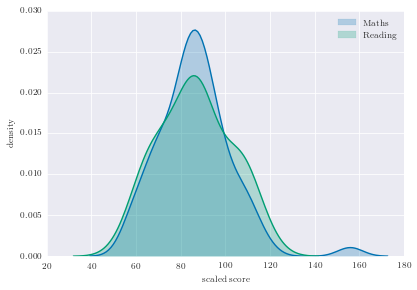

In [261]:
sns.kdeplot(df['Maths_std'].values, shade=True);
sns.kdeplot(df['Reading_std'].values, shade=True);
sns.axlabel('scaled score','density')
plt.legend(['Maths','Reading'])
plt.savefig(outpath + 'FA_connectome.png', dpi=300)

In [262]:
print('Maths: mean=' + str(round(mean(df['Maths_std']),2)) + ' SE=' + str(round(stats.sem(df['Maths_std']),3)))
print('Reading: mean=' + str(round(mean(df['Reading_std']),2)) + ' SE=' + str(round(stats.sem(df['Reading_std']),3)))

Maths: mean=86.37 SE=2.018
Reading: mean=86.42 SE=1.969


In [263]:
print('Percentage below average on Maths: ' + str(100*(round(float(sum(df['Maths_std'] < 85))/len(df),2))))
print('Percentage below average on Reading: ' + str(100*(round(float(sum(df['Reading_std'] < 85))/len(df),2))))

Percentage below average on Maths: 45.0
Percentage below average on Reading: 49.0


Testing if there is a difference between Reading and Maths scores:

In [264]:
print('Paired sample t-test to compared Maths and Reading scores: t(' + str(len(df) -1) + ')=' + 
    str(round(ttest_rel(df['Maths_std'].values, df['Reading_std'].values)[0],2)) + ', p=' + 
    str(round(ttest_rel(df['Maths_std'].values, df['Reading_std'].values)[1],3))
      )

Paired sample t-test to compared Maths and Reading scores: t(66)=-0.02, p=0.982


Breakdown of specificity/comorbidity of Maths and Reading deficits

In [265]:
print('Number of children with specific Maths deficit: ' + str(len(df[(df['Maths_std'] < 85) & (df['Reading_std'] > 90)])))
print('Number of children with specific Reading deficit: ' + str(len(df[(df['Maths_std'] > 90) & (df['Reading_std'] < 85)])))
print('Number of children with Maths and Reading deficits: ' + str(len(df[(df['Maths_std'] < 85) & (df['Reading_std'] < 85)])))
print('Number of children with no Maths nor Reading deficits: ' + str(len(df[(df['Maths_std'] > 90) & (df['Reading_std'] > 90)])))

Number of children with specific Maths deficit: 8
Number of children with specific Reading deficit: 6
Number of children with Maths and Reading deficits: 20
Number of children with no Maths nor Reading deficits: 15


## Analysis of graph measures

### Comparison to random graphs

In [266]:
# Setting up the progress bar
w = FloatProgress(value=0, min=0, max=100, step=0.1, description='Progress:')
display(w)
counter = 0
random_degree = list()

for i in range(0, consensus_matrices.shape[2]):
    data = consensus_matrices[...,i]
    subject = subjects[i]
        
    random_charpaths = list()
    random_clustcoefs = list()
    random_density = list() 
    random_strength = list()
    
    random_degrees = list()
    observed_degree = list()
    
    for i in range(0,20):
        random_data = data[np.random.permutation(data.shape[0])][np.random.permutation(data.shape[0])]
        random_charpaths.append(bct.charpath(bct.distance_wei(bct.weight_conversion(random_data, 'lengths'))[0])[0])
        random_clustcoefs.append(np.mean(bct.clustering_coef_wu(random_data)[np.isinf(bct.clustering_coef_wu(random_data)) == False]))
        random_density.append(bct.density_und(random_data)[0])
        random_strength.append(bct.strengths_und(random_data))
        random_degrees.append(sorted(bct.degrees_und(random_data), reverse=True))
        
    df.set_value(subject, 'random_charpath', np.mean(random_charpaths))
    df.set_value(subject, 'random_clustcoef', np.mean(random_clustcoefs))
    df.set_value(subject, 'random_density', np.mean(random_density))
    df.set_value(subject, 'random_strength', np.mean(random_strength))
    
    random_degree.append(np.mean(np.asarray(random_degrees),0))
    observed_degree.append(sorted(bct.degrees_und(data), reverse=True))
    
    counter += 1
    w.value = 100*(float(counter)/len(in_files))
    
w.close()

Plotting the degree distributions of observed and randomised data

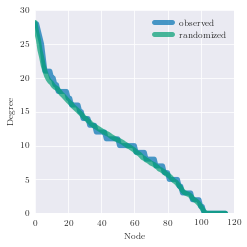

In [267]:
fig = plt.figure(num=None, figsize=(single_column, single_column), dpi=300, tight_layout=True, facecolor='white')
plt.plot(np.mean(observed_degree, 0), linewidth=5, alpha=0.7)
plt.plot(np.mean(random_degree, 0), linewidth=5, alpha=0.7)
plt.xlabel('Node')
plt.ylabel('Degree')
plt.legend(['observed','randomized'])
plt.savefig(outpath + 'Degree_distributions.png', dpi=300)

Checking that the mean node strength is the same in the observed and random networks

In [268]:
print('Observed strength: mean=' + str(round(mean(df['mean_strength']),2)) + ' SE=' + str(round(stats.sem(df['mean_strength']),3)))
print('Random strength: mean=' + str(round(mean(df['random_strength']),2)) + ' SE=' + str(round(stats.sem(df['random_strength']),3)))

print('Paired sample t-test to compare observed and random char. path length: t(' + str(len(df) -1) + ')=' + 
    str(round(ttest_rel(df['mean_strength'].values, df['random_strength'].values)[0],2)) + ', p=' + 
    str(round(ttest_rel(df['mean_strength'].values, df['random_strength'].values)[1],3))
      )

Observed strength: mean=1.99 SE=0.017
Random strength: mean=1.99 SE=0.017
Paired sample t-test to compare observed and random char. path length: t(66)=nan, p=nan


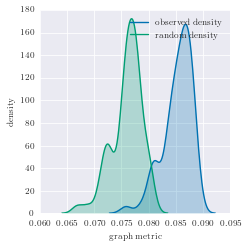

In [269]:
fig = plt.figure(num=None, figsize=(single_column, single_column), dpi=300, tight_layout=True, facecolor='white')
sns.kdeplot(df['graph_density'], shade=True)
sns.kdeplot(df['random_density'], shade=True)
sns.axlabel('graph metric','density')
plt.legend(['observed density','random density'])

In [270]:
print('Observed density: mean=' + str(round(mean(df['graph_density']),2)) + ' SE=' + str(round(stats.sem(df['graph_density']),3)))
print('Random density: mean=' + str(round(mean(df['random_charpath']),2)) + ' SE=' + str(round(stats.sem(df['random_charpath']),3)))

print('Paired sample t-test to compare observed and random char. path length: t(' + str(len(df) -1) + ')=' + 
    str(round(ttest_rel(df['characteristic_path_length'].values, df['random_charpath'].values)[0],2)) + ', p=' + 
    str(round(ttest_rel(df['characteristic_path_length'].values, df['random_charpath'].values)[1],3))
      )

Observed density: mean=0.09 SE=0.0
Random density: mean=11.36 SE=0.084
Paired sample t-test to compare observed and random char. path length: t(66)=39.63, p=0.0


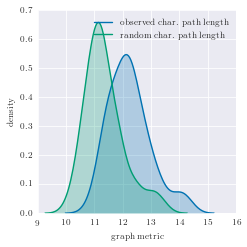

In [271]:
fig = plt.figure(num=None, figsize=(single_column, single_column), dpi=300, tight_layout=True, facecolor='white')
sns.kdeplot(df['characteristic_path_length'], shade=True)
sns.kdeplot(df['random_charpath'], shade=True)
sns.axlabel('graph metric','density')
plt.legend(['observed char. path length','random char. path length'])

In [272]:
print('Observed char. path length: mean=' + str(round(mean(df['characteristic_path_length']),2)) + ' SE=' + str(round(stats.sem(df['characteristic_path_length']),3)))
print('Random char. path length: mean=' + str(round(mean(df['random_charpath']),2)) + ' SE=' + str(round(stats.sem(df['random_charpath']),3)))

print('Paired sample t-test to compare observed and random char. path length: t(' + str(len(df) -1) + ')=' + 
    str(round(ttest_rel(df['characteristic_path_length'].values, df['random_charpath'].values)[0],2)) + ', p=' + 
    str(round(ttest_rel(df['characteristic_path_length'].values, df['random_charpath'].values)[1],3))
      )

Observed char. path length: mean=12.24 SE=0.09
Random char. path length: mean=11.36 SE=0.084
Paired sample t-test to compare observed and random char. path length: t(66)=39.63, p=0.0


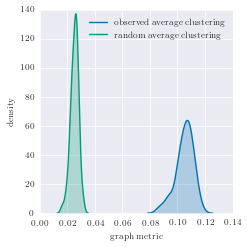

In [273]:
fig = plt.figure(num=None, figsize=(single_column, single_column), dpi=300, tight_layout=True, facecolor='white')
sns.kdeplot(df['average_clustering'], shade=True)
sns.kdeplot(df['random_clustcoef'], shade=True)
sns.axlabel('graph metric','density')
plt.legend(['observed average clustering','random average clustering'])

In [274]:
print('Observed char. path length: mean=' + str(round(mean(df['characteristic_path_length']),2)) + ' SE=' + str(round(stats.sem(df['characteristic_path_length']),3)))
print('Random char. path length: mean=' + str(round(mean(df['random_charpath']),2)) + ' SE=' + str(round(stats.sem(df['random_charpath']),3)))

print('Paired sample t-test to compare observed and random clustering coefficient: t(' + str(len(df) -1) + ')=' + 
    str(round(ttest_rel(df['average_clustering'].values, df['random_clustcoef'].values)[0],2)) + ', p=' + 
    str(round(ttest_rel(df['average_clustering'].values, df['random_clustcoef'].values)[1],3))
      )

Observed char. path length: mean=12.24 SE=0.09
Random char. path length: mean=11.36 SE=0.084
Paired sample t-test to compare observed and random clustering coefficient: t(66)=146.8, p=0.0


### Influence of nuisance variables

This section will assess the influence of intracranial volume (ICV), participant movement (Displacement), and graph density on the average clustering coefficient and characteristic path length of the FA network

$y = \beta_{ICV}X_{ICV} + \beta_{Movement}X_{Movement} + \beta_{Graph Density}X_{Graph Density} + \beta_{Intercept} + \epsilon$

In [275]:
ols('average_clustering ~ ICV + Displacement + graph_density', data=df_scaled).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     average_clustering   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     6.727
Date:                Wed, 26 Oct 2016   Prob (F-statistic):           0.000521
Time:                        10:01:25   Log-Likelihood:                -85.759
No. Observations:                  67   AIC:                             179.5
Df Residuals:                      63   BIC:                             188.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      2.776e-17      0.110   2.53e-16      1.000      -0.219       0.219
ICV              -0.1856      0.117     -1.579      0.119      -0.420       0.049
Displacement     -0.1159      0.110     -1.057      0.295      -0.335       0.103
graph_density     0.3842      0.117      3.271      0.002       0.149       0.619
==============================================================================
Omnibus:                        0.035   Durbin-Watson:                   2.086
Prob(Omnibus):                  0.982   Jarque-Bera (JB):                0.079
Skew:                           0.044   Prob(JB):                        0.961
Kurtosis:                       2.857   Cond. No.                         1.46
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Analysis of relationship between graph metrics and behavioural data

Regression models to assess the relationship between Maths and Reading ability and clustering coefficent and characteristic path length of the structural network

$Y_{Reading/Maths} = \beta_{CharPathLength}X_{CharPathLength} + \beta_{ICV}X_{ICV} + \beta_{Movement}X_{Movement} + \beta_{GraphDensity}X_{GraphDensity} + \beta_{Intercept} + \epsilon$

$Y_{Reading/Maths} = \beta_{AverageClustering}X_{AverageClustering} + \beta_{ICV}X_{ICV} + \beta_{Movement}X_{Movement} + \beta_{GraphDensity}X_{GraphDensity} + \beta_{Intercept} + \epsilon$

In [276]:
print('Effect of average clustering coefficient on Reading: beta=' +
    str(round(ols('Reading ~ average_clustering + ICV + Displacement + graph_density', data=df_scaled).fit().params['average_clustering'],2)) +
    ' p=' + 
    str(round(ols('Reading ~ average_clustering + ICV + Displacement + graph_density', data=df_scaled).fit().pvalues['average_clustering'],3))
      )

Effect of average clustering coefficient on Reading: beta=0.42 p=0.003


In [277]:
print('Effect of characteristic path length on Reading: beta=' +
    str(round(ols('Reading ~ characteristic_path_length + ICV + Displacement + graph_density', data=df_scaled).fit().params['characteristic_path_length'],2)) +
    ' p=' + 
    str(round(ols('Reading ~ characteristic_path_length + ICV + Displacement + graph_density', data=df_scaled).fit().pvalues['characteristic_path_length'],3))
      )

Effect of characteristic path length on Reading: beta=-0.53 p=0.0


In [278]:
print('Effect of average clustering coefficient on Maths: beta=' +
    str(round(ols('Maths ~ average_clustering + ICV + Displacement + graph_density', data=df_scaled).fit().params['average_clustering'],2)) +
    ' p=' + 
    str(round(ols('Maths ~ average_clustering + ICV + Displacement + graph_density', data=df_scaled).fit().pvalues['average_clustering'],3))
      )

Effect of average clustering coefficient on Maths: beta=0.43 p=0.002


In [279]:
print('Effect of average characteristic path length on Maths: beta=' +
    str(round(ols('Maths ~ characteristic_path_length + ICV + Displacement + graph_density', data=df_scaled).fit().params['characteristic_path_length'],2)) +
    ' p=' + 
    str(round(ols('Maths ~ characteristic_path_length + ICV + Displacement + graph_density', data=df_scaled).fit().pvalues['characteristic_path_length'],3))
      )

Effect of average characteristic path length on Maths: beta=-0.49 p=0.0


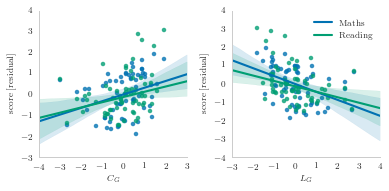

In [280]:
sns.set_style("whitegrid")
sns.set_style({'axes.grid': False,
               'font.family': [u'serif'],
               'font.sans-serif': [u'Computer Modern Unicode'],})

measures = ['average_clustering', 'characteristic_path_length']
legends = (r'$C_{G}$',r'$L_{G}$')
counter = 0

fig = plt.figure(figsize=(one_half_column, one_half_column/2), dpi=300, tight_layout=True)

for measure in measures:
    plt.subplot(1,2,counter+1)
    sns.regplot(df_scaled[measure].values, 
                ols('Reading ~ ICV + Displacement + graph_density', data=df_scaled).fit().resid, 
                ci=95, 
                robust=True)
    sns.regplot(df_scaled[measure].values, 
                ols('Maths ~ ICV + Displacement + graph_density', data=df_scaled).fit().resid, 
                ci=95, 
                robust=True)
    sns.axlabel(legends[counter],'score [residual]')
    if counter == 1:
        plt.legend(['Maths','Reading'])
    ax = fig.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    counter += 1
                 
plt.savefig(outpath + 'Regression_results.png', dpi=300)

### Saving the data

In [281]:
df_scaled = df_scaled.set_index(subjects)
df_scaled[['age','Maths','Reading','ICV','Displacement','graph_density']].to_csv(outpath + 'Variables.csv')

In [282]:
for i in range(0,consensus_matrices.shape[2]):
    np.savetxt(X = np.squeeze(consensus_matrices[...,i]),
              fname='/imaging/jb07/CALM/DWI/FA_connectome/all_connectomes/' + subjects[i] + '.txt')

In [283]:
np.savetxt(X = np.mean(consensus_matrices,2),
              fname='/imaging/jb07/CALM/DWI/FA_connectome/mean_connectome.txt')

## Group network analysis

In [284]:
group_network = np.mean(consensus_matrices,2)

In [285]:
group_df = pd.DataFrame()
group_df['label'] = ['Precentral_L', 'Precentral_R', 'Frontal_Sup_L', 'Frontal_Sup_R', 'Frontal_Sup_Orb_L', 'Frontal_Sup_Orb_R', 'Frontal_Mid_L', 'Frontal_Mid_R', 'Frontal_Mid_Orb_L', 'Frontal_Mid_Orb_R', 'Frontal_Inf_Oper_L', 'Frontal_Inf_Oper_R', 'Frontal_Inf_Tri_L', 'Frontal_Inf_Tri_R', 'Frontal_Inf_Orb_L', 'Frontal_Inf_Orb_R', 'Rolandic_Oper_L', 'Rolandic_Oper_R', 'Supp_Motor_Area_L', 'Supp_Motor_Area_R', 'Olfactory_L', 'Olfactory_R', 'Frontal_Sup_Medial_L', 'Frontal_Sup_Medial_R', 'Frontal_Med_Orb_L', 'Frontal_Med_Orb_R', 'Rectus_L', 'Rectus_R', 'Insula_L', 'Insula_R', 'Cingulum_Ant_L', 'Cingulum_Ant_R', 'Cingulum_Mid_L', 'Cingulum_Mid_R', 'Cingulum_Post_L', 'Cingulum_Post_R', 'Hippocampus_L', 'Hippocampus_R', 'ParaHippocampal_L', 'ParaHippocampal_R', 'Amygdala_L', 'Amygdala_R', 'Calcarine_L', 'Calcarine_R', 'Cuneus_L', 'Cuneus_R', 'Lingual_L', 'Lingual_R', 'Occipital_Sup_L', 'Occipital_Sup_R', 'Occipital_Mid_L', 'Occipital_Mid_R', 'Occipital_Inf_L', 'Occipital_Inf_R', 'Fusiform_L', 'Fusiform_R', 'Postcentral_L', 'Postcentral_R', 'Parietal_Sup_L', 'Parietal_Sup_R', 'Parietal_Inf_L', 'Parietal_Inf_R', 'SupraMarginal_L', 'SupraMarginal_R', 'Angular_L', 'Angular_R', 'Precuneus_L', 'Precuneus_R', 'Paracentral_Lobule_L', 'Paracentral_Lobule_R', 'Caudate_L', 'Caudate_R', 'Putamen_L', 'Putamen_R', 'Pallidum_L', 'Pallidum_R', 'Thalamus_L', 'Thalamus_R', 'Heschl_L', 'Heschl_R', 'Temporal_Sup_L', 'Temporal_Sup_R', 'Temporal_Pole_Sup_L', 'Temporal_Pole_Sup_R', 'Temporal_Mid_L', 'Temporal_Mid_R', 'Temporal_Pole_Mid_L', 'Temporal_Pole_Mid_R', 'Temporal_Inf_L', 'Temporal_Inf_R', 'Cerebelum_Crus1_L', 'Cerebelum_Crus1_R', 'Cerebelum_Crus2_L', 'Cerebelum_Crus2_R', 'Cerebelum_3_L', 'Cerebelum_3_R', 'Cerebelum_4_5_L', 'Cerebelum_4_5_R', 'Cerebelum_6_L', 'Cerebelum_6_R', 'Cerebelum_7b_L', 'Cerebelum_7b_R', 'Cerebelum_8_L', 'Cerebelum_8_R', 'Cerebelum_9_L', 'Cerebelum_9_R', 'Cerebelum_10_L', 'Cerebelum_10_R', 'Vermis_1_2', 'Vermis_3', 'Vermis_4_5', 'Vermis_6', 'Vermis_7', 'Vermis_8', 'Vermis_9', 'Vermis_10']

In [286]:
group_df['degree'] = bct.degrees_und(group_network)
group_df['clustering_coefficient'] = bct.clustering_coef_wu(group_network)
group_df['strength'] = bct.strengths_und(group_network)

newdata = data[bct.get_components(group_network, no_depend=True)[0] == 1, :] 
newdata = newdata[:, bct.get_components(group_network, no_depend=True)[0] == 1] 
components = bct.get_components(newdata, no_depend=True)
newdata = newdata[components[0] == 1, :]
newdata = newdata[:, components[0] == 1]
eccentricity = np.zeros(len(group_network))
eccentricity[np.unique(np.hstack([np.where(components[0] == 1), np.where(bct.get_components(group_network, no_depend=True)[0] == 1)]))] = bct.charpath(bct.distance_wei(bct.weight_conversion(newdata, 'lengths'))[0])[2]

group_df['eccentricity'] = eccentricity

group_df['rich_club'] = group_df['degree'] > np.mean(group_df['degree'].values) + np.std(group_df['degree'].values)

Getting graph metrics of nodes within and outside of the rich club

In [287]:
graph_df = pd.DataFrame()

# Setting up the progress bar
w = FloatProgress(value=0, min=0, max=100, step=0.1, description='Progress:')
display(w)
counter = 0

for i in range(0, consensus_matrices.shape[2]):
    data = consensus_matrices[...,i]
    subject = subjects[i]
    
    graph_df.set_value(subject, 'RC_clustering', np.mean(bct.clustering_coef_wu(data)[np.where(group_df['rich_club'].values == True)]))
    graph_df.set_value(subject, 'nonRC_clustering', np.mean(bct.clustering_coef_wu(data)[np.where(group_df['rich_club'].values == False)]))
    
    newdata = data[bct.get_components(data, no_depend=True)[0] == 1, :] 
    newdata = newdata[:, bct.get_components(data, no_depend=True)[0] == 1] 
    eccentricity = np.zeros(len(data))
    eccentricity[bct.get_components(data, no_depend=True)[0] == 1] = bct.charpath(bct.distance_wei(bct.weight_conversion(newdata, 'lengths'))[0])[2]
    
    graph_df.set_value(subject, 'RC_eccentricity', np.mean(eccentricity[np.where(group_df['rich_club'].values == True)]))
    graph_df.set_value(subject, 'nonRC_eccentricity', np.mean(eccentricity[np.where(group_df['rich_club'].values == False)]))
                  
    counter += 1
    w.value = 100*(float(counter)/len(in_files))
w.close()

graph_df = pd.DataFrame(scaler.fit_transform(graph_df), columns=graph_df.columns, index=graph_df.index)
df_scaled = pd.merge(df_scaled, graph_df, left_index=True, right_index=True)

In [288]:
print('Rich club clustering on Maths: beta=' +
      str(round(ols('Maths ~ RC_clustering + ICV + Displacement + graph_density', data=df_scaled).fit().params['RC_clustering'], 2)) +
      ' pvalue=' +
      str(round(ols('Maths ~ RC_clustering + ICV + Displacement + graph_density', data=df_scaled).fit().pvalues['RC_clustering'], 3)))

print('Peripheral clustering on Maths: beta=' +
      str(round(ols('Maths ~ nonRC_clustering + ICV + Displacement + graph_density', data=df_scaled).fit().params['nonRC_clustering'], 2)) + 
      ' pvalue=' + 
      str(round(ols('Maths ~ nonRC_clustering + ICV + Displacement + graph_density', data=df_scaled).fit().pvalues['nonRC_clustering'], 3)))

print('Rich club eccentricity on Maths: beta=' +
      str(round(ols('Maths ~ RC_eccentricity + ICV + Displacement + graph_density', data=df_scaled).fit().params['RC_eccentricity'], 2)) + 
      ' pvalue=' + 
      str(round(ols('Maths ~ RC_eccentricity + ICV + Displacement + graph_density', data=df_scaled).fit().pvalues['RC_eccentricity'], 3)))

print('Peripheral eccentricity on Maths: beta=' +
      str(round(ols('Maths ~ nonRC_eccentricity + ICV + Displacement + graph_density', data=df_scaled).fit().params['nonRC_eccentricity'], 2)) + 
      ' pvalue=' + 
      str(round(ols('Maths ~ nonRC_eccentricity + ICV + Displacement + graph_density', data=df_scaled).fit().pvalues['nonRC_eccentricity'], 3)))

Rich club clustering on Maths: beta=0.41 pvalue=0.002
Peripheral clustering on Maths: beta=0.42 pvalue=0.003
Rich club eccentricity on Maths: beta=-0.4 pvalue=0.003
Peripheral eccentricity on Maths: beta=-0.36 pvalue=0.005


In [289]:
print('Rich club clustering on Reading: beta=' +
      str(round(ols('Reading ~ RC_clustering + ICV + Displacement + graph_density', data=df_scaled).fit().params['RC_clustering'], 2)) +
      ' pvalue=' +
      str(round(ols('Reading ~ RC_clustering + ICV + Displacement + graph_density', data=df_scaled).fit().pvalues['RC_clustering'], 3)))

print('Peripheral clustering on Reading: beta=' +
      str(round(ols('Reading ~ nonRC_clustering + ICV + Displacement + graph_density', data=df_scaled).fit().params['nonRC_clustering'], 2)) + 
      ' pvalue=' + 
      str(round(ols('Reading ~ nonRC_clustering + ICV + Displacement + graph_density', data=df_scaled).fit().pvalues['nonRC_clustering'], 3)))

print('Rich club eccentricity on Reading: beta=' +
      str(round(ols('Reading ~ RC_eccentricity + ICV + Displacement + graph_density', data=df_scaled).fit().params['RC_eccentricity'], 2)) + 
      ' pvalue=' + 
      str(round(ols('Reading ~ RC_eccentricity + ICV + Displacement + graph_density', data=df_scaled).fit().pvalues['RC_eccentricity'], 3)))

print('Peripheral eccentricity on Reading: beta=' +
      str(round(ols('Reading ~ nonRC_eccentricity + ICV + Displacement + graph_density', data=df_scaled).fit().params['nonRC_eccentricity'], 2)) + 
      ' pvalue=' + 
      str(round(ols('Reading ~ nonRC_eccentricity + ICV + Displacement + graph_density', data=df_scaled).fit().pvalues['nonRC_eccentricity'], 3)))

Rich club clustering on Reading: beta=0.48 pvalue=0.0
Peripheral clustering on Reading: beta=0.39 pvalue=0.005
Rich club eccentricity on Reading: beta=-0.5 pvalue=0.0
Peripheral eccentricity on Reading: beta=-0.42 pvalue=0.001


### Targeted attack analysis

In [290]:
w = FloatProgress(value=0, min=0, max=100, step=0.1, description='Progress:')
display(w)

attack_df = pd.DataFrame()
value = 0.0001
max_repetitions = 20
maximum = 20
total_count = 0

RC_nodes = np.where(group_df['rich_club'] == True)[0]
Peripheral_nodes = np.where(group_df['rich_club'] == False)[0]

for attack_type in ['random', 'rich_club', 'peripheral']:
    counter = 1
    
    for counter in range(1,maximum):
            average_clusterings = list()
            characteristic_path_lengths = list()
            graph_densities = list()

            for repetitions in range(0,max_repetitions):
                target_network = np.mean(consensus_matrices,2)

                if attack_type == 'random':
                    target_network[np.random.randint(len(target_network), size=counter),:] = value
                    target_network[:,np.random.randint(len(target_network), size=counter)] = value
                if attack_type == 'rich_club':
                    target_network[np.random.permutation(RC_nodes)[0:counter],:] = value
                    target_network[:,np.random.permutation(RC_nodes)[0:counter]] = value
                if attack_type == 'peripheral':
                    target_network[np.random.permutation(Peripheral_nodes)[0:counter],:] = value
                    target_network[:,np.random.permutation(Peripheral_nodes)[0:counter]] = value

                average_clusterings.append(np.mean(bct.clustering_coef_wu(target_network)))
                characteristic_path_lengths.append(bct.charpath(bct.distance_wei(bct.weight_conversion(target_network, 'lengths'))[0])[0])
                graph_densities.append(bct.density_und(target_network)[0])

            attack_df.set_value(total_count, 'average_clustering', np.mean(average_clusterings))
            attack_df.set_value(total_count, 'nodes_missing', counter)
            attack_df.set_value(total_count, 'characteristic_path_length', np.mean(characteristic_path_lengths))
            attack_df.set_value(total_count, 'graph_density', np.mean(graph_densities))
            attack_df.set_value(total_count, 'attack_type', attack_type)
            
            counter += 1
            total_count += 1
            w.value = 100*(float(total_count)/(maximum*max_repetitions))
    
w.close()

In [291]:
w = FloatProgress(value=0, min=0, max=100, step=0.1, description='Progress:')
display(w)

attack_df = pd.DataFrame()
value = 0.0001
max_repetitions = 100
maximum = 20
total_count = 0

RC_nodes = np.where(group_df['rich_club'] == True)[0]
Peripheral_nodes = np.where(group_df['rich_club'] == False)[0]

for attack_type in ['random', 'rich_club', 'peripheral']:
    counter = 1
    
    for counter in range(1,maximum):
            average_clusterings = list()
            characteristic_path_lengths = list()
            graph_densities = list()

            for repetitions in range(0,max_repetitions):
                target_network = np.mean(consensus_matrices,2)

                if attack_type == 'random':
                    random_nodes = np.random.randint(len(target_network), size=counter)
                if attack_type == 'rich_club':
                    random_nodes = np.random.permutation(RC_nodes)[0:counter]
                if attack_type == 'peripheral':
                    random_nodes = np.random.permutation(Peripheral_nodes)[0:counter]
                    
                target_network[np.where(target_network[:, random_nodes] > 0)] = value
                target_network[np.where(target_network[random_nodes, :] > 0)] = value
                
                average_clusterings.append(np.mean(bct.clustering_coef_wu(target_network)))
                characteristic_path_lengths.append(bct.charpath(bct.distance_wei(bct.weight_conversion(target_network, 'lengths'))[0])[0])
                graph_densities.append(bct.density_und(target_network)[0])

            attack_df.set_value(total_count, 'average_clustering', np.mean(average_clusterings))
            attack_df.set_value(total_count, 'nodes_missing', counter)
            attack_df.set_value(total_count, 'characteristic_path_length', np.mean(characteristic_path_lengths))
            attack_df.set_value(total_count, 'graph_density', np.mean(graph_densities))
            attack_df.set_value(total_count, 'attack_type', attack_type)
            
            counter += 1
            total_count += 1
            w.value = 100*(float(total_count)/(maximum*max_repetitions))
    
w.close()

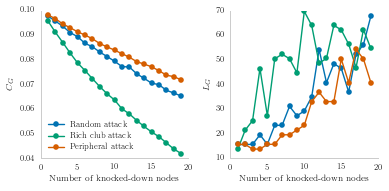

In [292]:
legends = (r'$C_{G}$', r'$L_{G}$', r'$D_{G}$')
counter = 0
plt.style.use(['seaborn-paper', 'seaborn-colorblind'])

fig = plt.figure(figsize=(one_half_column, one_half_column/2), dpi=300, tight_layout=True, facecolor='white', frameon=True)

for measure in ['average_clustering', 'characteristic_path_length']:
    plt.subplot(1,2,counter+1)
    plt.plot(attack_df[attack_df['attack_type'] == 'random']['nodes_missing'], attack_df[attack_df['attack_type'] == 'random'][measure], '-o')
    plt.plot(attack_df[attack_df['attack_type'] == 'rich_club']['nodes_missing'], attack_df[attack_df['attack_type'] == 'rich_club'][measure], '-o')
    plt.plot(attack_df[attack_df['attack_type'] == 'peripheral']['nodes_missing'], attack_df[attack_df['attack_type'] == 'peripheral'][measure], '-o')
    plt.xlabel('Number of knocked-down nodes')
    plt.ylabel(legends[counter])
    if counter == 0:
            plt.legend(['Random attack','Rich club attack', 'Peripheral attack'], loc='best')
    ax = fig.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    counter += 1
    
plt.savefig(outpath + 'Attack_results_S2.png', dpi=300, facecolor='white')

Re-scaling the variables for prediction in the original model

In [293]:
newdf = attack_df
newdf['average_clustering'] = attack_df['average_clustering'] - np.mean(df['average_clustering'])/np.std(df['average_clustering'])
newdf['characteristic_path_length'] = attack_df['characteristic_path_length'] - np.mean(df['characteristic_path_length'])/np.std(df['characteristic_path_length'])
newdf['graph_density'] = attack_df['graph_density'] - np.mean(df['graph_density'])/np.std(df['graph_density'])

In [294]:
df_predicted = pd.DataFrame()

counter = 0
average_clustering_results = list()
char_path_length_results = list()

df_residual = df
df_residual['Maths'] = ols('Maths ~ ICV + Displacement', data=df_scaled).fit().resid
df_residual['Reading'] = ols('Reading ~ ICV + Displacement', data=df_scaled).fit().resid

for outcome in ['Reading', 'Maths']:
    for attack_type in ['random', 'rich_club', 'peripheral']:
        for measure in ['average_clustering', 'characteristic_path_length']:

            if measure == 'average_clustering':
                model = ols(outcome + ' ~ average_clustering + graph_density', data=df_scaled).fit()
                result = model.predict(exog={'average_clustering':attack_df[attack_df['attack_type'] == attack_type][measure].values,
                                             'graph_density':attack_df[attack_df['attack_type'] == attack_type]['graph_density'].values})
                average_clustering_results.append(result)

            if measure == 'characteristic_path_length':
                model = ols(outcome + ' ~ characteristic_path_length + graph_density', data=df_scaled).fit()
                result = model.predict(exog={'characteristic_path_length':attack_df[attack_df['attack_type'] == attack_type][measure].values,
                                             'graph_density':attack_df[attack_df['attack_type'] == attack_type]['graph_density'].values})
                char_path_length_results.append(result)

In [295]:
predicted_df = pd.DataFrame({'characteristic_path_length':np.asarray(char_path_length_results).flatten(),
                             'average_clustering':np.asarray(average_clustering_results).flatten()})

In [296]:
predicted_df['outcome'] = np.hstack([np.repeat('Reading', len(predicted_df)/2),np.repeat('Maths', len(predicted_df)/2)])
predicted_df['attack_type'] = np.hstack([np.hstack([np.repeat('random', (len(predicted_df)/2)/3), 
            np.repeat('rich_club', (len(predicted_df)/2)/3), 
            np.repeat('peripheral', (len(predicted_df)/2)/3)]),
            np.hstack([np.repeat('random', (len(predicted_df)/2)/3), 
            np.repeat('rich_club', (len(predicted_df)/2)/3), 
            np.repeat('peripheral', (len(predicted_df)/2)/3)])])
predicted_df['nodes_missing'] = np.hstack([np.hstack([range(1,maximum), range(1,maximum), range(1,maximum)]),
                                           np.hstack([range(1,maximum), range(1,maximum), range(1,maximum)])])

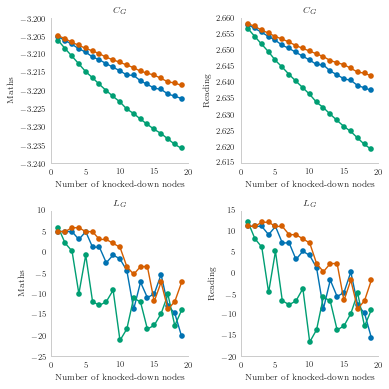

In [297]:
fig = plt.figure(figsize=(one_half_column,one_half_column), dpi=300, tight_layout=True, facecolor='white', frameon=True)
counter = 0

for measure in ['average_clustering', 'characteristic_path_length']:
    for outcome in ['Maths', 'Reading']:
        plt.subplot(2,2,counter+1)
        plt.plot(predicted_df[(predicted_df['attack_type'] == 'random') & (predicted_df['outcome'] == outcome)]['nodes_missing'], 
                 predicted_df[(predicted_df['attack_type'] == 'random') & (predicted_df['outcome'] == outcome)][measure], '-o')
        plt.plot(predicted_df[(predicted_df['attack_type'] == 'rich_club') & (predicted_df['outcome'] == outcome)]['nodes_missing'], 
                 predicted_df[(predicted_df['attack_type'] == 'rich_club') & (predicted_df['outcome'] == outcome)][measure], '-o')
        plt.plot(predicted_df[(predicted_df['attack_type'] == 'peripheral') & (predicted_df['outcome'] == outcome)]['nodes_missing'], 
                 predicted_df[(predicted_df['attack_type'] == 'peripheral') & (predicted_df['outcome'] == outcome)][measure], '-o')
        plt.xlabel('Number of knocked-down nodes')
        if counter < 2:
            plt.title(r'$C_{G}$')
        else:
            plt.title(r'$L_{G}$')
        if counter == 5:
            plt.legend(['Random attack','Rich club attack', 'Peripheral attack'], loc='best')
        plt.ylabel(outcome)
        ax = fig.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        counter += 1
        
plt.savefig(outpath + 'Attack_outcome_S2.png', dpi=300)

## Analysis of developmental effects

First, the direct relationships between age and Maths/Reading performance, and age and $C_{G}$ and $L_{G}$ are assessed

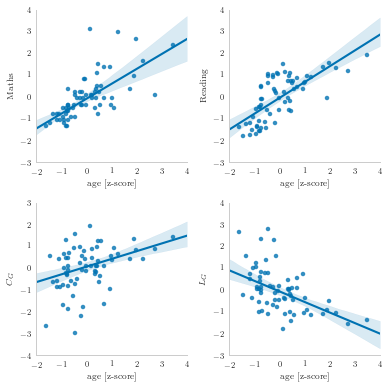

In [298]:
fig = plt.figure(figsize=(one_half_column,one_half_column), dpi=300, tight_layout=True, facecolor='white', frameon=True)
legends = ('Maths','Reading',r'$C_{G}$',r'$L_{G}$')
counter = 0

for measure in ['Maths','Reading','average_clustering','characteristic_path_length']:
    plt.subplot(2,2,counter+1)
    sns.regplot(df_scaled['age'].values, 
                df_scaled[measure],
                ci=95, 
                robust=True)
    plt.xlabel('age [z-score]')
    plt.ylabel(legends[counter])
    ax = fig.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    counter += 1

#### Linear models:

Maths and Reading scores predicted by age: $Y_{Maths/Reading} = \beta_{age}X_{age} + \beta_{Intercept} + \epsilon$

In [299]:
print('Effect of age on Maths: beta=' +
    str(round(ols('Maths ~ age', data=df_scaled).fit().params['age'],2)) +
    ' p=' + 
    str(round(ols('Maths ~ age', data=df_scaled).fit().pvalues['age'],3))
      )

print('Effect of age on Reading: beta=' +
    str(round(ols('Reading ~ age', data=df_scaled).fit().params['age'],2)) +
    ' p=' + 
    str(round(ols('Reading ~ age', data=df_scaled).fit().pvalues['age'],3))
      )

Effect of age on Maths: beta=0.69 p=0.0
Effect of age on Reading: beta=0.71 p=0.0


$C_{G}$ and $L_{G}$ predicted by age: $Y_{C_{G}/L_{G}} = \beta_{age}X_{age} + \beta_{ICV}X_{ICV} + \beta_{Movement}X_{Movement} + \beta_{D_{G}}X_{D_{G}} + \beta_{Intercept} + \epsilon$

In [300]:
print('Effect of age on $C_{G}$: beta=' +
    str(round(ols('average_clustering ~ age + ICV + Displacement + graph_density', data=df_scaled).fit().params['age'],2)) +
    ' p=' + 
    str(round(ols('average_clustering ~ age + ICV + Displacement + graph_density', data=df_scaled).fit().pvalues['age'],3))
      )

print('Effect of age on $L_{G}$: beta=' +
    str(round(ols('characteristic_path_length ~ age + ICV + Displacement + graph_density', data=df_scaled).fit().params['age'],2)) +
    ' p=' + 
    str(round(ols('characteristic_path_length ~ age + ICV + Displacement + graph_density', data=df_scaled).fit().pvalues['age'],3))
      )

Effect of age on $C_{G}$: beta=0.34 p=0.001
Effect of age on $L_{G}$: beta=-0.48 p=0.0


**Conclusion**: Age strongly predicts improvements in behavioural scores as well as increases in $C_{G}$ and decreases in $L_{G}$

### Influence of rich club and peripheral nodes

In [301]:
w = FloatProgress(value=0, min=0, max=100, step=0.1, description='Progress:')
display(w)

measures_df = pd.DataFrame()
average_clusterings = list()
characteristic_path_lengths = list()
graph_densities = list()

RC_nodes = np.where(group_df['rich_club'] == True)[0]
Peripheral_nodes = np.where(group_df['rich_club'] == False)[0]

for counter in range(0,consensus_matrices.shape[2]):
    network = consensus_matrices[...,counter]
    measures_df.set_value(counter, 'richclub_clustering', np.mean(bct.clustering_coef_wu(network)[RC_nodes]))
    measures_df.set_value(counter, 'peripheral_clustering', np.mean(bct.clustering_coef_wu(network)[Peripheral_nodes]))
    
    G = nx.from_numpy_matrix(network)
    subG = G.subgraph(sorted(nx.connected_components(G), key = len, reverse=True)[0])
    eccentricity = np.zeros(network.shape[0])
    counter2 = 0
    for entry in nx.eccentricity(subG).keys():
        eccentricity[entry] = nx.eccentricity(subG).values()[counter2]
        counter2 += 1
        
    measures_df.set_value(counter, 'richclub_eccentricity', np.mean(eccentricity[RC_nodes]))
    measures_df.set_value(counter, 'peripheral_eccentricity', np.mean(eccentricity[Peripheral_nodes]))
    w.value = 100*(float(counter)/(consensus_matrices.shape[2]-1))
    
# Scaling to mean and unit variance
scaler = StandardScaler()
measures_df = pd.DataFrame(scaler.fit_transform(measures_df), 
                         columns=measures_df.columns)
measures_df.index = df.index

# Adding other regressors
measures_df['age'] = df_scaled['age']
measures_df['ICV'] = df_scaled['ICV']
measures_df['graph_density'] = df_scaled['graph_density']
measures_df['Displacement'] = df_scaled['Displacement']

w.close()

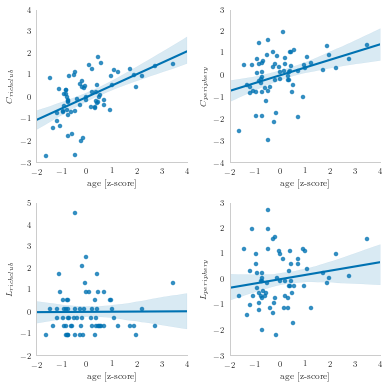

In [302]:
fig = plt.figure(figsize=(one_half_column,one_half_column), dpi=300, tight_layout=True, facecolor='white', frameon=True)
legends = ('$C_{rich club}$','$C_{periphery}$','$L_{rich club}$','$L_{periphery}$')
counter = 0

for measure in ['richclub_clustering','peripheral_clustering','richclub_eccentricity','peripheral_eccentricity']:
    plt.subplot(2,2,counter+1)
    sns.regplot(df_scaled['age'].values, 
                measures_df[measure],
                ci=95, 
                robust=False)
    plt.xlabel('age [z-score]')
    plt.ylabel(legends[counter])
    ax = fig.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    counter += 1

Regression models to establish the relationship between age and graph measures for rich club and periperhal nodes

In [303]:
print('Effect of age on rich club clustering: beta=' +
    str(round(ols('age ~ richclub_clustering + ICV + Displacement + graph_density', data=measures_df).fit().params['richclub_clustering'], 2)) +
    ' p=' + 
    str(round(ols('age ~ richclub_clustering + ICV + Displacement + graph_density', data=measures_df).fit().pvalues['richclub_clustering'], 3)))

print('Effect of age on peripheral clustering: beta=' +
    str(round(ols('age ~ peripheral_clustering + ICV + Displacement + graph_density', data=measures_df).fit().params['peripheral_clustering'], 2)) +
    ' p=' + 
    str(round(ols('age ~ peripheral_clustering + ICV + Displacement + graph_density', data=measures_df).fit().pvalues['peripheral_clustering'], 3)))

Effect of age on rich club clustering: beta=0.59 p=0.0
Effect of age on peripheral clustering: beta=0.4 p=0.004


## Comparing results to scrambled networks

run nodes up to 'getting graph measures' again, then proceed with the next cell

In [304]:
# Setting up the progress bar
w = FloatProgress(value=0, min=0, max=100, step=0.1, description='Progress:')
display(w)
counter = 0
random_degree = list()

for i in range(0, consensus_matrices.shape[2]):
    data = consensus_matrices[...,i]
    subject = subjects[i]
        
    random_charpaths = list()
    random_clustcoefs = list()
    random_density = list() 
    random_strength = list()
    
    random_degrees = list()
    observed_degree = list()
    
    for i in range(0,20):
        random_data = data[np.random.permutation(data.shape[0])][np.random.permutation(data.shape[0])]
        random_charpaths.append(bct.charpath(bct.distance_wei(bct.weight_conversion(random_data, 'lengths'))[0])[0])
        random_clustcoefs.append(np.mean(bct.clustering_coef_wu(random_data)[np.isinf(bct.clustering_coef_wu(random_data)) == False]))
        random_density.append(bct.density_und(random_data)[0])
        random_strength.append(bct.strengths_und(random_data))
        random_degrees.append(sorted(bct.degrees_und(random_data), reverse=True))
        
    df.set_value(subject, 'random_charpath', np.mean(random_charpaths))
    df.set_value(subject, 'random_clustcoef', np.mean(random_clustcoefs))
    df.set_value(subject, 'random_density', np.mean(random_density))
    df.set_value(subject, 'random_strength', np.mean(random_strength))
    
    random_degree.append(np.mean(np.asarray(random_degrees),0))
    observed_degree.append(sorted(bct.degrees_und(data), reverse=True))
    
    counter += 1
    w.value = 100*(float(counter)/len(in_files))
    
w.close()

In [305]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[['age', 'Maths_std','Reading_std', 'Maths', 'Reading', 'ICV', 'Displacement', 'random_charpath', 'random_clustcoef','random_density']]), 
                         columns=['age', 'Maths_std','Reading_std', 'Maths', 'Reading', 'ICV', 'Displacement', 'random_charpath', 'random_clustcoef','random_density'])
df_scaled['Gender'] = df['Gender'].values
df_scaled.index = df.index

In [306]:
print('Effect of average clustering coefficient on Reading: beta=' +
    str(round(ols('Reading ~ random_clustcoef + ICV + Displacement + random_density', data=df_scaled).fit().params['average_clustering'],2)) +
    ' p=' + 
    str(round(ols('Reading ~ random_clustcoef + ICV + Displacement + random_density', data=df_scaled).fit().pvalues['average_clustering'],3))
      )

KeyError: 'average_clustering'

In [ ]:
print('Effect of characteristic path length on Reading: beta=' +
    str(round(ols('Reading ~ random_charpath + ICV + Displacement + random_density', data=df_scaled).fit().params['characteristic_path_length'],2)) +
    ' p=' + 
    str(round(ols('Reading ~ random_charpath + ICV + Displacement + random_density', data=df_scaled).fit().pvalues['characteristic_path_length'],3))
      )

In [ ]:
print('Effect of average clustering coefficient on Maths: beta=' +
    str(round(ols('Maths ~ random_clustcoef + ICV + Displacement + random_density', data=df_scaled).fit().params['average_clustering'],2)) +
    ' p=' + 
    str(round(ols('Maths ~ random_clustcoef + ICV + Displacement + random_density', data=df_scaled).fit().pvalues['average_clustering'],3))
      )

In [ ]:
print('Effect of average characteristic path length on Maths: beta=' +
    str(round(ols('Maths ~ random_charpath + ICV + Displacement + random_density', data=df_scaled).fit().params['characteristic_path_length'],2)) +
    ' p=' + 
    str(round(ols('Maths ~ random_charpath + ICV + Displacement + random_density', data=df_scaled).fit().pvalues['characteristic_path_length'],3))
      )

In [ ]:
pearsonr(df_scaled['age'], df_scaled['Maths'])

In [ ]:
df_bootstrap = pd.DataFrame()
for outcome in ['Maths', 'Reading']:
    for graph_measure in ['average_clustering', 'characteristic_path_length']:
        
        for i in range(0,100):
            random_sample = np.random.permutation(df_scaled.shape[0])[0:25]
            df_bootstrap.set_value(i, 'controlled', sqrt(pearsonr(df_scaled['age'][random_sample], ols(outcome + ' ~ ' + graph_measure, data=df_scaled.iloc[random_sample]).fit().resid)[0]))
            df_bootstrap.set_value(i, 'original', sqrt(pearsonr(df_scaled['age'][random_sample], df_scaled[outcome][random_sample])[0]))

        print(outcome)
        print(graph_measure)
        print('Original data: mean=' + str(round(100*np.mean(df_bootstrap['original'].values), 2)) + ', SE=' + str(round(100*stats.sem(df_bootstrap['original'].values), 3)))
        print('Controlled data: mean=' + str(round(100*np.mean(df_bootstrap['controlled'].values), 2)) + ', SE=' + str(round(100*stats.sem(df_bootstrap['controlled'].values), 3)))
        print('t-test: t=' + str(round(ttest_ind(df_bootstrap['original'].values, df_bootstrap['controlled'].values)[0],2)) + ', p=' + str(round(ttest_ind(df_bootstrap['original'].values, df_bootstrap['controlled'].values)[1],3))) 

## Comparison analysis with TBSS

In [ ]:
def get_subject_behavioural_data(subject):
    import json
    behavioural = eval(open('/imaging/jb07/CALM/CALM_BIDS/' + subject + '/beh/' + subject + '_beh.txt', 'r').read().replace("NaN","float('nan')").replace("null","float('nan')"))
    behavioural.update(eval(open('/imaging/jb07/CALM/CALM_BIDS/' + subject + '/' + subject + '_demographics.txt', 'r').read().replace("NaN","float('nan')").replace("null","float('nan')")))

    return behavioural

In [ ]:
def get_behavioural_data():
    w = FloatProgress(value=0, min=0, max=100, step=0.1, description='Progress:')
    display(w)
    counter = 0

    folder = '/imaging/jb07/CALM/DWI/FA_connectome/'
    df = pd.DataFrame()
    in_files = [folder + subfolder + '/calc_matrix/coreg_tracks_FA_matrix.txt' for subfolder in os.listdir(folder) if os.path.isfile(folder + subfolder + '/calc_matrix/coreg_tracks_FA_matrix.txt')]
    networks = list()
    subjects = list()

    # Getting all the datab
    for subfolder in os.listdir(folder):
        if os.path.isfile(folder + subfolder + '/calc_matrix/coreg_tracks_FA_matrix.txt'):
            subject = subfolder.split('_')[-1]

            # Getting behavioural measures
            df.set_value(subject,'age', get_subject_behavioural_data(subject)['Age_in_months'])
            #df.set_value(subject, 'Gender', get_subject_behavioural_data(subject)['Gender'])
            df.set_value(subject, 'Maths', get_subject_behavioural_data(subject)['WIAT_Numerical_raw'])
            df.set_value(subject, 'Reading', get_subject_behavioural_data(subject)['WIAT_Reading_Raw'])

            df.set_value(subject, 'Maths_std', get_subject_behavioural_data(subject)['WIAT_Numerical_Std'])
            df.set_value(subject, 'Reading_std', get_subject_behavioural_data(subject)['WIAT_Reading_Std'])

            # Getting graph measures
            data = np.loadtxt(folder + subfolder + '/calc_matrix/coreg_tracks_FA_matrix.txt')
            networks.append(data[1:,1:])
            subjects.append(subject)

            # Progress bar
            counter += 1
            w.value = 100*(float(counter)/len(in_files))
    w.close()

    df = df.replace(999,float('nan'))
    df = df.dropna()

    df['age'] = df['age'].apply(lambda x: pd.to_numeric(x, errors='coerce'))
    df['Maths'] = df['Maths'].apply(lambda x: pd.to_numeric(x, errors='coerce'))
    df['Reading'] = df['Reading'].apply(lambda x: pd.to_numeric(x, errors='coerce'))
    df['Maths_std'] = df['Maths_std'].apply(lambda x: pd.to_numeric(x, errors='coerce'))
    df['Reading_std'] = df['Reading_std'].apply(lambda x: pd.to_numeric(x, errors='coerce'))

    ICV = pd.read_csv('/imaging/jb07/CALM/T1/volume_results.csv')
    ICV['ICV'] = ICV['GM_volume_0'].values*ICV['GM_volume_2'] + ICV['WM_volume_0'].values*ICV['WM_volume_2']
    ICV = ICV[['MRI.ID','ICV']].set_index(['MRI.ID'])
    df = pd.merge(df, ICV, left_index=True, right_index=True)

    movement = pd.read_csv('/imaging/jb07/CALM/DWI/motion_estimation/Displacements_Results.csv')
    movement.columns = ['MRI.ID','Displacement']
    df = pd.merge(df, movement.set_index(['MRI.ID']), left_index=True, right_index=True)
    df = df[df['Displacement'] < 3]
    
    return df

In [ ]:
def copy_data(df, in_folder, out_folder):
    import nipype.interfaces.mrtrix as mrt
    from nipype.interfaces.fsl.maths import ApplyMask
    from shutil import copyfile 
    
    w = FloatProgress(value=0, min=0, max=100, step=0.1, description='Progress:')
    display(w)
    counter = 0
    
    for subject_id in df.index.values:
        mrconvert = mrt.MRConvert()
        mrconvert.inputs.in_file = in_folder + '_subject_id_' + subject_id + '/tensor2fa/' + subject_id + '_dwi_denoised_edc_reslice_tensor_FA.mif'
        mrconvert.inputs.out_filename = out_folder + subject_id + '.nii'
        mrconvert.run()

        applymask = ApplyMask()
        applymask.inputs.in_file = out_folder + subject_id + '.nii'
        applymask.inputs.mask_file = in_folder + '_subject_id_' + subject_id + '/bet/' + subject_id + '_dwi_denoised_edc_reslice_b0_brain_mask.nii.gz'
        applymask.inputs.out_file = out_folder + subject_id + '_FA.nii.gz'
        applymask.run()

        os.remove(out_folder + subject_id + '.nii')

        copyfile(in_folder + '_subject_id_' + subject_id + '/bet/' + subject_id + '_dwi_denoised_edc_reslice_b0_brain_mask.nii.gz',
                 out_folder + subject_id + '_FA_mask.nii.gz')
        # Progress bar
        counter += 1
        w.value = 100*(float(counter)/len(df.index.values))
        
    w.close()
    display.clear_output()

In [ ]:
in_folder = '/imaging/jb07/CALM/DWI/FA_connectome/'
out_folder = '/imaging/jb07/CALM/DWI/FA_connectome/group_comparison/'
copy_data(get_behavioural_data(), in_folder, out_folder + 'FA/')

Processing of FA images with the TBSS pipeline

In [ ]:
template = '/imaging/jb07/CALM/CALM_template.nii.gz'

run_tbss = open(out_folder + 'run_tbss.sh', 'w')
run_tbss.write('cd ' + out_folder + ' \n')
run_tbss.write('tbss_2_reg -t ' + template + ' \n')
run_tbss.write('tbss_3_postreg -S \n')
run_tbss.write('tbss_4_prestats 0.2')
run_tbss.close()

#call('qsub ' + out_folder + 'run_tbss.sh', shell=True)

In [ ]:
tbss_folder = '/imaging/jb07/CALM/DWI/FA_connectome/group_comparison/'

Creating the design and contrast matrix for FSL randomise

In [ ]:
def create_design_mat(df, filename):
    design_mat = open(tbss_folder + '/stats/' + filename + '.mat', 'w')
    design_mat.write('/NumWaves ' + str(np.shape(df)[1]) + '\n')
    design_mat.write('/NumPoints ' + str(np.shape(df)[0]) + '\n')
    design_mat.write('/Matrix \n')
    
    for row in df.values:
        string = ''
        for value in row:
           string = string + str(value) + ' '
        design_mat.write(string + '\n')
        
    design_mat.close()

In [ ]:
design = """
/ContrastName1 "G1 > G2"
/ContrastName2 "G1 < G2"
/NumWaves 2
/NumContrasts 2
/PPheights 1 1

/Matrix
1 -1
-1 1
"""

design_file = open(tbss_folder + '/stats/design.con', 'w')
design_file.write(design)
design_file.close()

In [ ]:
def run_randomise(tbss_folder, df, filename):
    create_design_mat(df, filename)

    randomise_command = open(tbss_folder + '/stats/run_randomise.sh', 'w')
    randomise_command.write('cd ' + tbss_folder + 'stats/ \n')
    randomise_command.write('randomise -i all_FA_skeletonised -o ' + filename + ' -m mean_FA_skeleton_mask -d '+ filename + '.mat -t design.con -n 500 --T2')
    randomise_command.close()
    call('qsub ' + tbss_folder + '/stats/run_randomise.sh', shell=True)

Creating median splits

In [ ]:
df = get_behavioural_data()
df['age_demeaned'] = df['age'].values - np.mean(df['age'].values)

df['Maths_deficit'] = 1*(df['Maths_std'].values.astype('int') <= np.median(df['Maths_std'].values.astype('int')))
df['Maths_typical'] = 1*(df['Maths_std'].values.astype('int') > np.median(df['Maths_std'].values.astype('int')))
run_randomise(tbss_folder, df[['Maths_deficit', 'Maths_typical']].sort_index(), 'Maths_median_split_std')
run_randomise(tbss_folder, df[['Maths_deficit', 'Maths_typical', 'age_demeaned']].sort_index(), 'Maths_median_split_std_woAge')

df['Reading_deficit'] = 1*(df['Reading_std'].values.astype('int') <= np.median(df['Reading_std'].values.astype('int')))
df['Reading_typical'] = 1*(df['Reading_std'].values.astype('int') > np.median(df['Reading_std'].values.astype('int')))
run_randomise(tbss_folder, df[['Reading_deficit', 'Reading_typical']].sort_index(), 'Reading_median_split_std')
run_randomise(tbss_folder, df[['Reading_deficit', 'Reading_typical', 'age_demeaned']].sort_index(), 'Reading_median_split_std_woAge')

In [ ]:
print('Number Maths deficit: ' + str(np.sum(df['Maths_deficit'].values)))
print('Number Maths typical: ' + str(np.sum(df['Maths_typical'].values)))
print('Number Reading deficit: ' + str(np.sum(df['Reading_deficit'].values)))
print('Number Reading typical: ' + str(np.sum(df['Reading_typical'].values)))

In [ ]:
print('Maths deficit mean score: ' + str(round(np.mean(df[df['Maths_deficit'] == 1]['Maths_std']), 2)) + 
      ' SE: ' + str(round(sem(df[df['Maths_deficit'] == 1]['Maths_std']), 3)))

print('Maths typical mean score: ' + str(round(np.mean(df[df['Maths_typical'] == 1]['Maths_std']), 2)) + 
      ' SE: ' + str(round(sem(df[df['Maths_typical'] == 1]['Maths_std']), 3)))

print('Reading deficit mean score: ' + str(round(np.mean(df[df['Reading_deficit'] == 1]['Reading_std']), 2)) + 
      ' SE: ' + str(round(sem(df[df['Reading_deficit'] == 1]['Reading_std']), 3)))

print('Reading typical mean score: ' + str(round(np.mean(df[df['Reading_typical'] == 1]['Reading_std']), 2)) + 
      ' SE: ' + str(round(sem(df[df['Reading_typical'] == 1]['Reading_std']), 3)))

In [ ]:
print('Maths deficit age: mean=' + str(round(np.mean(df[df['Maths_deficit'] == 1]['age'].values), 2)) + 
      ' SE=' + str(round(sem(df[df['Maths_deficit'] == 1]['age'].values), 3)))
print('Maths typical age: mean=' + str(round(np.mean(df[df['Maths_typical'] == 1]['age'].values), 2)) + 
      ' SE=' + str(round(sem(df[df['Maths_typical'] == 1]['age'].values), 3)))
print('Reading deficit age: mean=' + str(round(np.mean(df[df['Reading_deficit'] == 1]['age'].values), 2)) + 
      ' SE=' + str(round(sem(df[df['Reading_deficit'] == 1]['age'].values), 3)))
print('Reading typical age: mean=' + str(round(np.mean(df[df['Reading_typical'] == 1]['age'].values), 2)) + 
      ' SE=' + str(round(sem(df[df['Reading_typical'] == 1]['age'].values), 3)))

In [ ]:
print('Maths group age comparison: t(' + str((len(df['Maths_deficit'].values) - 2)) + ')=' + 
str(round(ttest_ind(df[df['Maths_deficit'] == 1]['age'].values, df[df['Maths_typical'] == 1]['age'].values)[0],2)) + 
' p=' + str(round(ttest_ind(df[df['Maths_deficit'] == 1]['age'].values, df[df['Maths_typical'] == 1]['age'].values)[1],3)))

print('Reading group age comparison: t(' + str((len(df['Reading_deficit'].values) - 2)) + ')=' + 
str(round(ttest_ind(df[df['Reading_deficit'] == 1]['age'].values, df[df['Reading_typical'] == 1]['age'].values)[0],2)) + 
' p=' + str(round(ttest_ind(df[df['Reading_deficit'] == 1]['age'].values, df[df['Reading_typical'] == 1]['age'].values)[1],3)))

In [ ]:
filename = 'Maths_median_split_std'
template = '/imaging/jb07/CALM/CALM_template.nii.gz'

stat_image = tbss_folder + 'stats/' + filename + '_tfce_corrp_tstat1.nii.gz'
plotting.plot_stat_map(stat_image, bg_img=template,
                       title="low Maths $<$ high Maths",
                       threshold = 0.95,
                       cmap = 'Reds',
                       vmax = 1,
                       display_mode='z', cut_coords=[-5, 0, 5, 10, 15, 25],
                       black_bg=False, dim=.5)

stat_image = tbss_folder + 'stats/' + filename + '_tfce_corrp_tstat2.nii.gz'
plotting.plot_stat_map(stat_image, bg_img=template,
                       title="high Maths $<$ low Maths",
                       threshold = 0.95,
                       cmap = 'Reds',
                       vmax = 1,
                       display_mode='z', cut_coords=[-5, 0, 5, 10, 15, 25],
                       black_bg=False, dim=.5,
                       annotate = False)

In [ ]:
filename = 'Reading_median_split_std'
stat_image = tbss_folder + 'stats/' + filename + '_tfce_corrp_tstat1.nii.gz'
plotting.plot_stat_map(stat_image, bg_img=template,
                       title="low Reading $<$ high Reading",
                       threshold = 0.95,
                       cmap = 'Reds',
                       vmax = 1,
                       display_mode='z', cut_coords=[-5, 0, 5, 10, 15, 25],
                       black_bg=False, dim=.5,
                       annotate = False)

stat_image = tbss_folder + 'stats/' + filename + '_tfce_corrp_tstat2.nii.gz'
plotting.plot_stat_map(stat_image, bg_img=template,
                       title="high Reading $<$ low Reading",
                       threshold = 0.95,
                       cmap = 'Reds',
                       vmax = 1,
                       display_mode='z', cut_coords=[-5, 0, 5, 10, 15, 25],
                       black_bg=False, dim=.5,
                       annotate = False)